In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

import keras
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import MaxPooling1D, GlobalMaxPooling1D
from keras.layers import Input
from keras.layers import Dense, Flatten, Dropout
from keras.initializers import Constant
from keras.models import Model

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics

import pandas as pd
import re
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import pickle
import numpy as np

In [126]:
topics_data = pd.read_csv('Flair_data.csv')  #total points 2782
topics_data.head(2)

,Unnamed: 0,flair,title,score,id,url,comms_num,created,body,author,comments,over_18
0,0,AskIndia,4 days ago we had pending orders of 100 millio...,97,fwjdqr,https://www.reddit.com/r/india/comments/fwjdqr...,6,1.586290e+09,> We are getting frantic calls from our pharma...,india_ko_vanakkam,"Modi has Stockholm syndrome To be fair, the e...",False
1,1,AskIndia,Randians who were big time users of dating app...,19,fizkkk,https://www.reddit.com/r/india/comments/fizkkk...,19,1.584298e+09,I'd my own stint with these apps(a couple of m...,__knockknockturnal__,Someone matched with me just to tell me that ...,False


In [127]:
# topics_data["flair"] == 'AskIndia'

In [128]:
#EDA
#count no of points of each flair
flairs = ["AskIndia", "Coronavirus", "Non-Political", "[R]eddiquette", "Scheduled", "Photography", "Science/Technology",
          "Politics", "Business/Finance", "Policy/Economy", "Sports", "Food", "AMA"]
flair_count = [(i, len(topics_data[topics_data["flair"] == i])) for i in flairs]

In [ ]:
flair_count

In [ ]:
plt.figure(figsize=(20, 5))
plt.hist(topics_data.flair)
plt.show()

##  ('[R]eddiquette', 18) points are very less - so removing this flair

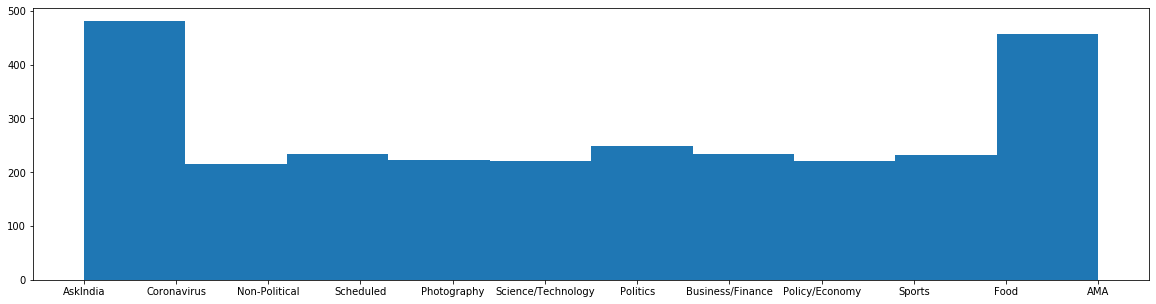

[('AskIndia', 232),
 ('Coronavirus', 249),
 ('Non-Political', 216),
 ('[R]eddiquette', 0),
 ('Scheduled', 234),
 ('Photography', 222),
 ('Science/Technology', 221),
 ('Politics', 249),
 ('Business/Finance', 233),
 ('Policy/Economy', 220),
 ('Sports', 232),
 ('Food', 244),
 ('AMA', 212)]

In [7]:
topics_data = topics_data[topics_data["flair"] != "[R]eddiquette"]
plt.figure(figsize=(20, 5))
plt.hist(topics_data.flair)
plt.show()
flair_count = [(i, len(topics_data[topics_data["flair"] == i])) for i in flairs]
flair_count

In [8]:
topics_data[topics_data["over_18"] == True] #None

,Unnamed: 0,flair,title,score,id,url,comms_num,created,body,author,comments,over_18


In [9]:
# Check for nan or deleted or removed 
empties = ['nan', '[deleted]', '[removed]']
for empty in empties:
    print(empty, len(topics_data[topics_data['body'] == empty]))

nan 0
[deleted] 0
[removed] 0


In [10]:
topics_data['body'] = topics_data['body'].apply(lambda x: '' if x in empties else x)

In [16]:
# Check for nan or deleted or removed 
empties = ['nan', '[deleted]', '[removed]']
for empty in empties:
    print(empty, len(topics_data[topics_data['body'] == empty]))

nan 0
[deleted] 0
[removed] 0


In [18]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def get_date(created):
    return dt.datetime.fromtimestamp(created)

def string_form(value):
    return str(value)

def clean_text(text):
    text = BeautifulSoup(text, "lxml").text
    text = text.lower()
    text = REPLACE_BY_SPACE_RE.sub(' ', text)
    text = BAD_SYMBOLS_RE.sub('', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)
    return text

In [20]:
#Convert the text in string
topics_data['title'] = topics_data['title'].apply(string_form)
topics_data['body'] = topics_data['body'].apply(string_form)
topics_data['comments'] = topics_data['comments'].apply(string_form)

#Clean Text
topics_data['title'] = topics_data['title'].apply(clean_text)
topics_data['body'] = topics_data['body'].apply(clean_text)
topics_data['comments'] = topics_data['comments'].apply(clean_text)

feature_combine = topics_data["title"] + topics_data["comments"] + topics_data["body"]
feature_combine_title_n_body = topics_data["title"] + topics_data["body"]
topics_data = topics_data.assign(feature_combine = feature_combine)
topics_data = topics_data.assign(title_n_body = feature_combine_title_n_body)

/usr/lib/python3/dist-packages/bs4/__init__.py:282: UserWarning: "https://youtu.be/kBvIqVr__C0" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


In [21]:
topics_data.head()

,Unnamed: 0,flair,title,score,id,url,comms_num,created,body,author,comments,over_18,feature_combine,title_n_body
0,0,AskIndia,4 days ago pending orders 100 million hydroxyc...,97,fwjdqr,https://www.reddit.com/r/india/comments/fwjdqr...,6,1.586290e+09,getting frantic calls pharma customers delayed...,india_ko_vanakkam,modi stockholm syndrome fair evidence chloroqu...,False,4 days ago pending orders 100 million hydroxyc...,4 days ago pending orders 100 million hydroxyc...
1,1,AskIndia,randians big time users dating apps like tinde...,19,fizkkk,https://www.reddit.com/r/india/comments/fizkkk...,19,1.584298e+09,id stint apps couple months one point didnt fe...,__knockknockturnal__,someone matched tell im fat cat 1 general foll...,False,randians big time users dating apps like tinde...,randians big time users dating apps like tinde...
2,2,AskIndia,r india thinks flat earthers,7,f25vx0,https://www.reddit.com/r/india/comments/f25vx0...,31,1.581441e+09,encountered foreigner ig says round earth hoax...,Dev1003,havent found indian yet believes earth flat de...,False,r india thinks flat earthershavent found india...,r india thinks flat earthersencountered foreig...
3,3,AskIndia,people left 9 5 jobs pursue career music art f...,45,dtvliq,https://www.reddit.com/r/india/comments/dtvliq...,34,1.573333e+09,couldnt add askindia flair mobile browser,c0mrade34,engineer advertisement shoots since last 1year...,False,people left 9 5 jobs pursue career music art f...,people left 9 5 jobs pursue career music art f...
4,4,AskIndia,somebody want kill full family,91,b7pvwt,https://www.reddit.com/r/india/comments/b7pvwt...,24,1.554080e+09,24hrs local police station register case dont ...,amitkumarthakur,calm downgo sp office town file grievance imme...,False,somebody want kill full familycalm downgo sp o...,somebody want kill full family24hrs local poli...


Title word count lengths: 
 Min: 1 
 Max: 35 
 Average: 8.955499276410999
Comments word count lengths: 
 Min: 1 
 Max: 58215 
 Average: 326.089001447178
Body word count lengths: 
 Min: 1 
 Max: 3603 
 Average: 113.90159189580318
Title n Body (combined) word count lengths: 
 Min: 1 
 Max: 3620 
 Average: 121.85709117221418


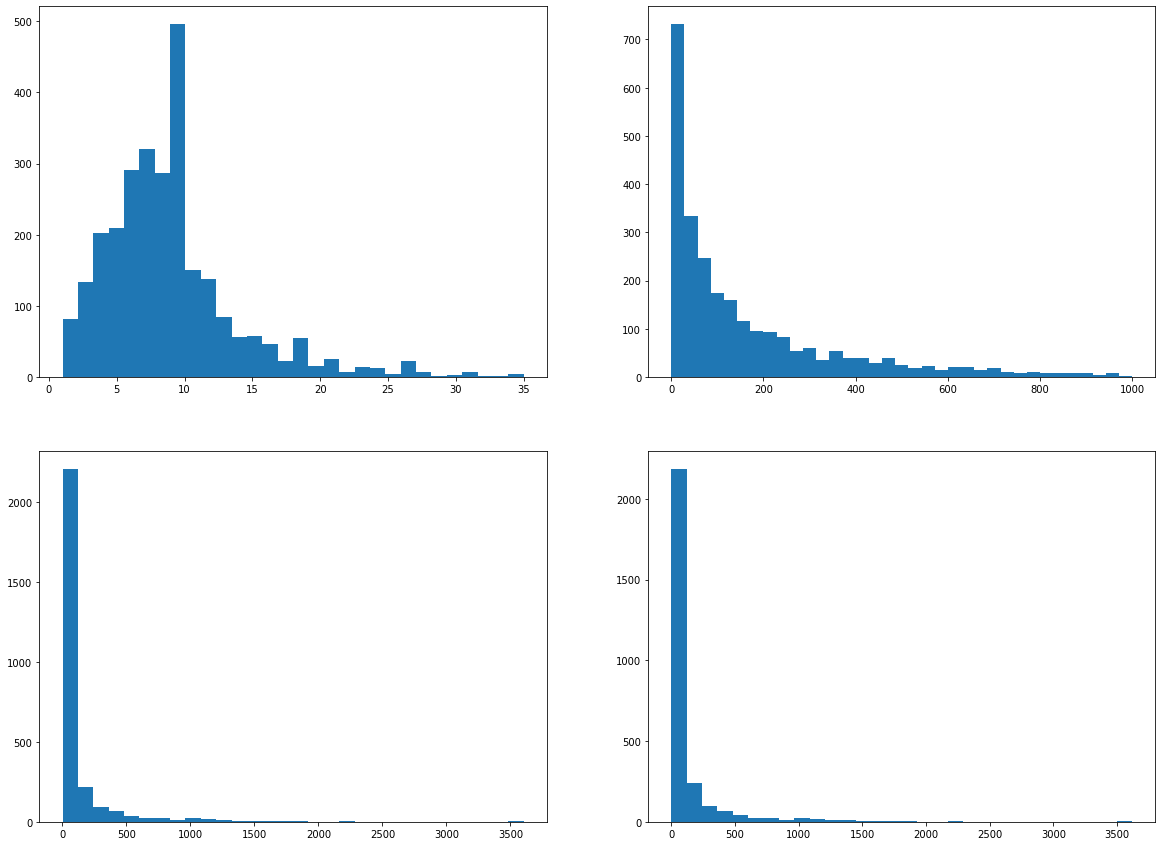

In [40]:
# # average length of titles with min and max
# # count the numbers of words in each title and calculate the min and max
plt.figure(figsize=(20,15))
plt.subplot(221)
title_word_lengths = [len(str(topics_data.title.iloc[i]).split(' ')) for i in range(len(topics_data))]
max_title_word_length = max(title_word_lengths)
min_title_word_length = min(title_word_lengths)
average_title_word_length = sum(title_word_lengths)/len(title_word_lengths)
plt.hist(title_word_lengths, bins = 30)

plt.subplot(222)
# average length of comments with min and max
comments_word_lengths = [len(str(topics_data.comments.iloc[i]).split(' ')) for i in range(len(topics_data))]
max_comments_word_length = max(comments_word_lengths)
min_comments_word_length = min(comments_word_lengths)
average_comments_word_length = sum(comments_word_lengths)/len(comments_word_lengths)
plt.hist(comments_word_lengths, bins = 35, range=[0, 1000], align='mid')

plt.subplot(223)
# #average length of body with min and max
body_word_lengths = [len(str(topics_data.body.iloc[i]).split(' ')) for i in range(len(topics_data))]
max_body_word_length = max(body_word_lengths)
min_body_word_length = min(body_word_lengths)
average_body_word_length = sum(body_word_lengths)/len(body_word_lengths)
plt.hist(body_word_lengths, bins = 30)

plt.subplot(224)
#average length of title and body combined with min and max
tnb_word_lengths = [len(str(topics_data.title_n_body.iloc[i]).split(' ')) for i in range(len(topics_data))]
max_tnb_word_length = max(tnb_word_lengths)
min_tnb_word_length = min(tnb_word_lengths)
average_tnb_word_length = sum(tnb_word_lengths)/len(tnb_word_lengths)
plt.hist(tnb_word_lengths, bins = 30)

print('Title word count lengths: \n Min: {} \n Max: {} \n Average: {}'.format(min_title_word_length, max_title_word_length, average_title_word_length))
print('Comments word count lengths: \n Min: {} \n Max: {} \n Average: {}'.format(min_comments_word_length, max_comments_word_length, average_comments_word_length))
print('Body word count lengths: \n Min: {} \n Max: {} \n Average: {}'.format(min_body_word_length, max_body_word_length, average_body_word_length))
print('Title n Body (combined) word count lengths: \n Min: {} \n Max: {} \n Average: {}'.format(min_tnb_word_length, max_tnb_word_length, average_tnb_word_length))


In [ ]:
MAX_NUM_WORDS =  200000  #Max unique words that can be in a <text_type> (Comments, Body, Title)
#From the above plots we can decide the max length of title, comments, body to consider
#We keep in mind, not to make those the title word to vec arrays much sparse
#Cropping of text from comments/body after a certain length will not make much loss
MAX_TITLE_LENGTH =  20      #The average lenth of title is 9 words. And maximum is 35, so we can use 
                            #around 20 words in the title, and remove/pad
                            #the remaining word spaces
MAX_COMMENTS_LENGTH = 200
MAX_BODY_LENGTH = 150

## Loading Glove Embeddings kept in my local Harddisk.
## It can be Downloaded from here https://nlp.stanford.edu/projects/glove/
## Large file - so cant upload in github repo

In [43]:
# Load pickle of glove embeddings
EMBEDDING_DIM = 300 #300d glove embeddings
embedding_index_glove_300d = open("/media/ankur/05328ADB2605E075/MIDAS-MELD-DATASET/MELD.Raw/dev/" + 
                                  "dev_text_embedding_index_glove_300d.pickle","rb")
text_embedding_index_glove_300d = pickle.load(embedding_index_glove_300d)

## Machine learning algorithms cannot work with raw text directly. Rather, the text must be converted into vectors of numbers.

## The following code cell takes the text data and converts into word to vector 
## 1. Loads the Glove embedding
## 2. Makes the dictionary from the words available in text.
## 3. Find out the words in text already present in glove.
## 4. Replaces the word with 300 dimensional word vector.
## These embeddings (glove) are very well trained embeddings on huge corpus of text.
## The words of similar types have larger correlation i.e. for example
## the feature vectors of mango and apple will be similar in terms of class fruit.|

In [44]:
def make_embedding_matrix(text, max_sequence_length, text_type, pickle_tokenizer):
    #Make sure glove embedding is loaded in text_embedding_index_glove_300d
    tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
    tokenizer.fit_on_texts(text)
    
    if(pickle_tokenizer):
        pickle_tokenizer = open(f"{text_type}_tokenizer.pickle","wb")
        pickle.dump(tokenizer, pickle_tokenizer)
        pickle_tokenizer.close()    
        
    sequences = tokenizer.texts_to_sequences(text)
    padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length)
    word_index = tokenizer.word_index
    print('Found {} unique tokens. of {}'.format(len(word_index), text_type))
    #Create embedding_matrix
    num_words = min(MAX_NUM_WORDS, len(word_index) + 1)
    embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
    words_not_in_glove = []
    for word, i in word_index.items():
        if i >= MAX_NUM_WORDS:
            continue
        embedding_vector = text_embedding_index_glove_300d.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
        else:
            #the words not found are stored here
            words_not_in_glove.append((word, i))
    print("Shape of embedding matrix of {} type is {}".format(text_type, embedding_matrix.shape))
    #Pickle embedding_matrix (save embedding matrix for <text_type>)
#     pickle_embedding_matrix = open(f"{text_type}_embedding_matrix.pickle","wb")
#     pickle.dump(embedding_matrix, pickle_embedding_matrix)
#     pickle_embedding_matrix.close()
    print(f"Out of {len(word_index)} words, {len(words_not_in_glove)} words are not in glove embeddings")
    return ({"tokenizer" : tokenizer, 
             "padded_sequences" : padded_sequences,
             "max_sequence_length" : max_sequence_length,
             "words_not_in_glove" : words_not_in_glove, 
             "embedding_matrix" : embedding_matrix})

## Text Model

In [70]:
title_encoded = make_embedding_matrix(topics_data.title, MAX_TITLE_LENGTH , 'title', pickle_tokenizer = 1)
body_encoded = make_embedding_matrix(topics_data.body, MAX_BODY_LENGTH , 'body', pickle_tokenizer = 1)
title_n_body_encoded = make_embedding_matrix(topics_data.title_n_body, MAX_TITLE_LENGTH + MAX_BODY_LENGTH , 'body', pickle_tokenizer = 1)
title_n_body_n_comment_encoded = make_embedding_matrix(topics_data.feature_combine, MAX_TITLE_LENGTH + MAX_BODY_LENGTH + MAX_COMMENTS_LENGTH, 'body', pickle_tokenizer = 1)

Found 7357 unique tokens. of title
Shape of embedding matrix of title type is (7358, 300)
Out of 7357 words, 692 words are not in glove embeddings
Found 37972 unique tokens. of body
Shape of embedding matrix of body type is (37973, 300)
Out of 37972 words, 15503 words are not in glove embeddings
Found 41222 unique tokens. of body
Shape of embedding matrix of body type is (41223, 300)
Out of 41222 words, 17975 words are not in glove embeddings
Found 96529 unique tokens. of body
Shape of embedding matrix of body type is (96530, 300)
Out of 96529 words, 56194 words are not in glove embeddings


In [93]:
#Make training Data
#Converting Flair to One-Hot

label_encode_dict = {'AskIndia': 0,
                         'Coronavirus': 1,
                         'Non-Political': 2,
                         'Scheduled': 3,
                         'Photography': 4,
                         'Science/Technology': 5,
                         'Politics': 6,
                         'Business/Finance': 7,
                         'Policy/Economy': 8,
                         'Sports': 9,
                         'Food': 10,
                         'AMA': 11}

# label_decode_dict = {v: k for k, v in label_encode_dict.items()}

label_decode_dict = {0: 'AskIndia',
                         1: 'Coronavirus',
                         2: 'Non-Political',
                         3: 'Scheduled',
                         4: 'Photography',
                         5: 'Science/Technology',
                         6: 'Politics',
                         7: 'Business/Finance',
                         8: 'Policy/Economy',
                         9: 'Sports',
                         10: 'Food',
                         11: 'AMA'}
def label_encode(label):
    return label_encode_dict.get(label)
def label_decode(label_value):
    return label_decode_dict.get(label_value)


# onehot_encoder = OneHotEncoder(sparse=False)
# Y = onehot_encoder.fit_transform(Y.reshape(-1, 1))
#Decode using [label_decode(v) for v in Y.argmax(axis = 1)]

In [46]:
# Convert Flairs to One Hot Encoding
Y = topics_data["flair"]
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(Y)
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
Y = onehot_encoder.fit_transform(integer_encoded)

### To invert One Hot Encoding
inverted = label_encoder.inverse_transform([argmax(onehot_encoded[0, :])])
print(inverted)

In [48]:
X_title = title_encoded["padded_sequences"]
X_body = body_encoded["padded_sequences"]
X_title_n_body = title_n_body_encoded["padded_sequences"]
X_title_n_body_n_comment = title_n_body_n_comment_encoded["padded_sequences"]

In [71]:
print("Title: {} words not in glove from a total of {} words".format( len(title_encoded["words_not_in_glove"]), len(title_encoded["tokenizer"].word_index) + 1))
print("Body: {} words not in glove from a total of {} words".format( len(body_encoded["words_not_in_glove"]), len(body_encoded["tokenizer"].word_index) + 1))
print("title_n_body: {} words not in glove from a total of {} words".format( len(title_n_body_encoded["words_not_in_glove"]), len(title_n_body_encoded["tokenizer"].word_index) + 1))
print("title_n_body_n_comment: {} words not in glove from a total of {} words".format( len(title_n_body_n_comment_encoded["words_not_in_glove"]), len(title_n_body_n_comment_encoded["tokenizer"].word_index) + 1))

Title: 692 words not in glove from a total of 7358 words
Body: 15503 words not in glove from a total of 37973 words
title_n_body: 17975 words not in glove from a total of 41223 words
title_n_body_n_comment: 56194 words not in glove from a total of 96530 words


In [72]:
#Example words not present in the Glove embeddings
title_n_body_n_comment_encoded["words_not_in_glove"]

#Most words are Hindi Words -> Appun, Bhaiya, etc.. , joined words

[('twittercom', 59),
 ('covid19', 156),
 ('wwwredditcom', 214),
 ('articleshow', 444),
 ('wwwyoutubecom', 513),
 ('imgurcom', 727),
 ('youve', 765),
 ('aadhaar', 778),
 ('mobiletwittercom', 858),
 ('economictimesindiatimescom', 895),
 ('askindia', 897),
 ('iimgurcom', 905),
 ('shouldnt', 908),
 ('wwwthehinducom', 949),
 ('covid', 1122),
 ('aadhar', 1164),
 ('enwikipediaorg', 1196),
 ('wwwgooglecom', 1228),
 ('timesofindiaindiatimescom', 1277),
 ('indianexpresscom', 1365),
 ('techeconomictimesindiatimescom', 1380),
 ('theyll', 1399),
 ('indianews', 1426),
 ('npredditcom', 1482),
 ('itll', 1495),
 ('wwwndtvcom', 1497),
 ('bhakts', 1554),
 ('wwwlivemintcom', 1559),
 ('zomato', 1630),
 ('subreddit', 1761),
 ('wwwindiatodayin', 1770),
 ('demonetisation', 1771),
 ('theyve', 1773),
 ('githubcom', 1874),
 ('ettech', 1925),
 ('wwwnews18com', 2192),
 ('swiggy', 2193),
 ('flipkart', 2223),
 ('1html', 2256),
 ('techcirclevccirclecom', 2272),
 ('modiji', 2286),
 ('samacharbot2', 2295),
 ('bjps', 23

In [73]:
print(X_title.shape)
print(X_body.shape)
print(X_title_n_body.shape)
print(X_title_n_body_n_comment.shape)
print(Y.shape)

(2764, 20)
(2764, 150)
(2764, 170)
(2764, 370)
(2764, 12)


# Define Model 1

In [84]:
def model_1(num_words, em, max_sequence_length):
    embedding_layer = Embedding(num_words,
                                EMBEDDING_DIM,
                                embeddings_initializer=Constant(em),
                                input_length=max_sequence_length,
                                trainable=True)
    input_text_ = Input(shape = (max_sequence_length,), dtype = 'int32')
    embedded_sequences = embedding_layer(input_text_)
    output_text_ = Dropout(0.2)(embedded_sequences)
    output_text_ = Conv1D(64, 3, activation='relu')(output_text_)
    output_text_ = MaxPooling1D(2)(output_text_)
    output_text_ = Conv1D(100, 3, activation='relu')(output_text_)
    output_text_ = MaxPooling1D(2)(output_text_)
    output_text_ = Flatten()(output_text_)
    output_text_ = Dense(12, activation='softmax')(output_text_)

    model_text = Model(inputs = input_text_, outputs = output_text_)
    print(model_text.summary())
    return model_text

In [85]:
def compile_n_train(model, X_train, Y_train, X_test, Y_test, batch_size, epochs, optimizer = 'adam', save = 0, save_name = 'test'):
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    model.fit(X_train, Y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(X_test, Y_test))
    if(save):
        model.save(f"{save_name}.h5")
        print("MODEL SAVED AS {}".format(save_name))

#### Define Model1

#### Compile and rain Model1

In [81]:
num_words = min(MAX_NUM_WORDS, len(title_encoded["tokenizer"].word_index) + 1)
model = model_1(num_words, title_encoded["embedding_matrix"], MAX_TITLE_LENGTH)

# Train Test Split titles
X_train, X_test, Y_train, Y_test = train_test_split(
    X_title, Y, test_size=0.25, random_state=42)
compile_n_train(model, X_train, Y_train, X_test, Y_test, 32, 10, save = 0, save_name='model2')

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 20)                0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 20, 300)           2207400   
_________________________________________________________________
dropout_2 (Dropout)          (None, 20, 300)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 18, 64)            57664     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 9, 64)             0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 7, 100)            19300     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 3, 100)            0   

/home/ankur/.local/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 2073 samples, validate on 691 samples
Epoch 1/10
2073/2073 [==============================] - 3s 1ms/step - loss: 0.2729 - accuracy: 0.9178 - val_loss: 0.2466 - val_accuracy: 0.9209
Epoch 2/10
2073/2073 [==============================] - 3s 1ms/step - loss: 0.2114 - accuracy: 0.9292 - val_loss: 0.1953 - val_accuracy: 0.9395
Epoch 3/10
2073/2073 [==============================] - 3s 1ms/step - loss: 0.1547 - accuracy: 0.9473 - val_loss: 0.1814 - val_accuracy: 0.9407
Epoch 4/10
2073/2073 [==============================] - 3s 1ms/step - loss: 0.1160 - accuracy: 0.9605 - val_loss: 0.1760 - val_accuracy: 0.9444
Epoch 5/10
2073/2073 [==============================] - 3s 1ms/step - loss: 0.0890 - accuracy: 0.9709 - val_loss: 0.1797 - val_accuracy: 0.9433
Epoch 6/10
2073/2073 [==============================] - 3s 1ms/step - loss: 0.0691 - accuracy: 0.9770 - val_loss: 0.1903 - val_accuracy: 0.9430
Epoch 7/10
2073/2073 [==============================] - 3s 1ms/step - loss: 0.0547 - accu

### ^^^^^^^^^^^^^^^
## With Only titles
#### Classification Accuracy Model1 with inputs only title, for 10 epoch is 
#### Train_acc = 98.8 % , Val_acc = 93.77%


In [ ]:
#Test Model
predicted = model.predict(X_test)

#Check some Predictions
Y_predicted_decoded = label_encoder.inverse_transform(predicted.argmax(axis = 1)[20:22])
Y_test_decoded = label_encoder.inverse_transform(Y_test.argmax(axis = 1)[20:22])

print(Y_predicted_decoded, Y_test_decoded)

#Confusion Matrix
classes = [label_decode(v) for v in [0,1,2,3,4,5,6,7,8,9,10,11]]
print(classes)
cm = metrics.confusion_matrix(Y_test.argmax(axis = 1), predicted.argmax(axis = 1))
cm

In [87]:
# With Title and Body
# Train Test Split titles and body
num_words = min(MAX_NUM_WORDS, len(title_n_body_encoded["tokenizer"].word_index) + 1)
model = model_1(num_words, title_n_body_encoded["embedding_matrix"], MAX_TITLE_LENGTH + MAX_BODY_LENGTH)


X_train, X_test, Y_train, Y_test = train_test_split(
    X_title_n_body, Y, test_size=0.25, random_state=42)
compile_n_train(model, X_train, Y_train, X_test, Y_test, 32, 10, save = 0, save_name='model2')

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 170)               0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 170, 300)          12366900  
_________________________________________________________________
dropout_4 (Dropout)          (None, 170, 300)          0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 168, 64)           57664     
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 84, 64)            0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 82, 100)           19300     
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 41, 100)           0   

/home/ankur/.local/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 2073 samples, validate on 691 samples
Epoch 1/10
2073/2073 [==============================] - 16s 8ms/step - loss: 0.2769 - accuracy: 0.9168 - val_loss: 0.2615 - val_accuracy: 0.9173
Epoch 2/10
2073/2073 [==============================] - 16s 8ms/step - loss: 0.2284 - accuracy: 0.9223 - val_loss: 0.2248 - val_accuracy: 0.9214
Epoch 3/10
2073/2073 [==============================] - 16s 8ms/step - loss: 0.1581 - accuracy: 0.9426 - val_loss: 0.2062 - val_accuracy: 0.9329
Epoch 4/10
2073/2073 [==============================] - 16s 8ms/step - loss: 0.1014 - accuracy: 0.9658 - val_loss: 0.2086 - val_accuracy: 0.9372
Epoch 5/10
2073/2073 [==============================] - 16s 8ms/step - loss: 0.0700 - accuracy: 0.9774 - val_loss: 0.2107 - val_accuracy: 0.9362
Epoch 6/10
2073/2073 [==============================] - 16s 8ms/step - loss: 0.0521 - accuracy: 0.9850 - val_loss: 0.2219 - val_accuracy: 0.9381
Epoch 7/10
2073/2073 [==============================] - 16s 8ms/step - loss: 0.0429

## With  titles and Body
#### Classification Accuracy Model1 with inputs only title, for 10 epoch is 
#### Train_acc = 99.3 % , Val_acc = 94.36%

In [88]:
#Test Model
predicted = model.predict(X_test)

#Check some Predictions
Y_predicted_decoded = label_encoder.inverse_transform(predicted.argmax(axis = 1)[20:22])
Y_test_decoded = label_encoder.inverse_transform(Y_test.argmax(axis = 1)[20:22])

print(Y_predicted_decoded, Y_test_decoded)

#Confusion Matrix
classes = [label_decode(v) for v in [0,1,2,3,4,5,6,7,8,9,10,11]]
print(classes)
cm = metrics.confusion_matrix(Y_test.argmax(axis = 1), predicted.argmax(axis = 1))
cm

# Define Model 2  -- LSTM

In [121]:
def model_2(num_words, em, max_sequence_length, with_dropout):
    embedding_layer = Embedding(num_words,
                                    EMBEDDING_DIM,
                                    embeddings_initializer=Constant(em),
                                    input_length=max_sequence_length,
                                    trainable=False)
    input_text_ = Input(shape = (max_sequence_length,), dtype = 'int32')
    embedded_sequences = embedding_layer(input_text_)
    if(with_dropout):
        output_text_ = Dropout(0.2)(embedded_sequences)
        output_text_ = keras.layers.LSTM(max_sequence_length, activation='tanh')(output_text_)
    else:
        output_text_ = keras.layers.LSTM(max_sequence_length, activation='tanh')(embedded_sequences)
    if(with_dropout):
        output_text_ = Dropout(0.2)(output_text_)
    output_text_ = keras.layers.Dense(12, activation='softmax')(output_text_)
    model = Model(inputs = input_text_, outputs = output_text_)
    print(model.summary())
    return model

#### Define Model2

### Train and Save model With DROPOUT with Only Title

In [122]:
num_words = min(MAX_NUM_WORDS, len(title_encoded["tokenizer"].word_index) + 1)
model = model_2(num_words, title_encoded["embedding_matrix"], MAX_TITLE_LENGTH, with_dropout=1)

X_train, X_test, Y_train, Y_test = train_test_split(
    X_title, Y, test_size=0.25, random_state=42)
compile_n_train(model, X_train, Y_train, X_test, Y_test, 32, 10, save = 1, save_name='final_model') 
######################### SAVING THE MODEL h5 file as the final_model.h5  ########################

Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        (None, 20)                0         
_________________________________________________________________
embedding_18 (Embedding)     (None, 20, 300)           2207400   
_________________________________________________________________
dropout_18 (Dropout)         (None, 20, 300)           0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 20)                25680     
_________________________________________________________________
dropout_19 (Dropout)         (None, 20)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 12)                252       
Total params: 2,233,332
Trainable params: 25,932
Non-trainable params: 2,207,400
___________________________________________

#### Classification Accuracy Model2 with inputs only title, for 10 epoch is 
#### Train_acc = 96.08 % , Val_acc = 95.71%

In [123]:
#Test Model
predicted = model.predict(X_test)

#Check some Predictions
Y_predicted_decoded = label_encoder.inverse_transform(predicted.argmax(axis = 1)[20:22])
Y_test_decoded = label_encoder.inverse_transform(Y_test.argmax(axis = 1)[20:22])

print(Y_predicted_decoded, Y_test_decoded)

#Confusion Matrix
classes = [label_decode(v) for v in [0,1,2,3,4,5,6,7,8,9,10,11]]
print(classes)
cm = metrics.confusion_matrix(Y_test.argmax(axis = 1), predicted.argmax(axis = 1))
cm

['Food' 'Coronavirus'] ['Food' 'Coronavirus']
['AskIndia', 'Coronavirus', 'Non-Political', 'Scheduled', 'Photography', 'Science/Technology', 'Politics', 'Business/Finance', 'Policy/Economy', 'Sports', 'Food', 'AMA']


array([[46,  0,  1,  0,  0,  0,  0,  0,  0,  2,  0,  1],
       [ 0, 24,  6,  2,  5,  0,  2,  5,  1,  3,  4,  4],
       [ 0,  9, 26,  0,  1,  1,  2, 11,  2,  2,  3,  1],
       [ 0,  1,  0, 67,  1,  0,  0,  0,  0,  0,  1,  0],
       [ 0,  3,  0,  4, 50,  0,  1,  1,  0,  1,  0,  0],
       [ 0,  0,  0,  1,  0, 51,  0,  0,  0,  0,  0,  0],
       [ 2,  4,  2,  0,  0,  0, 37,  0,  1,  2,  3,  0],
       [ 0,  9,  6,  1,  2,  2,  1, 27,  7,  0,  1,  1],
       [ 0,  4,  2,  4,  3,  3,  0,  9, 38,  2,  1,  0],
       [ 0,  6,  4,  0,  1,  0,  3,  3,  2, 27,  4,  0],
       [ 0,  5, 16,  2,  0,  0,  2,  2,  1,  2, 32,  2],
       [ 1,  2,  2,  1,  0,  1,  3,  3,  3,  3,  0, 38]])

### Train and Save model With DROPOUT with Title and Body

In [124]:
# With Title and Body
# Train Test Split titles and body
num_words = min(MAX_NUM_WORDS, len(title_n_body_encoded["tokenizer"].word_index) + 1)
model = model_2(num_words, title_n_body_encoded["embedding_matrix"], MAX_TITLE_LENGTH + MAX_BODY_LENGTH, with_dropout=1)


X_train, X_test, Y_train, Y_test = train_test_split(
    X_title_n_body, Y, test_size=0.25, random_state=42)
compile_n_train(model, X_train, Y_train, X_test, Y_test, 32, 10, save = 0, save_name='model_lstm')

Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        (None, 170)               0         
_________________________________________________________________
embedding_19 (Embedding)     (None, 170, 300)          12366900  
_________________________________________________________________
dropout_20 (Dropout)         (None, 170, 300)          0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 170)               320280    
_________________________________________________________________
dropout_21 (Dropout)         (None, 170)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 12)                2052      
Total params: 12,689,232
Trainable params: 322,332
Non-trainable params: 12,366,900
________________________________________

#### Classification Accuracy Model2 with inputs  title and Body, for 10 epoch is 
#### Train_acc = 95.50 % , Val_acc = 94.56%

In [125]:
#Test Model
predicted = model.predict(X_test)

#Check some Predictions
Y_predicted_decoded = label_encoder.inverse_transform(predicted.argmax(axis = 1)[20:22])
Y_test_decoded = label_encoder.inverse_transform(Y_test.argmax(axis = 1)[20:22])

print(Y_predicted_decoded, Y_test_decoded)

#Confusion Matrix
classes = [label_decode(v) for v in [0,1,2,3,4,5,6,7,8,9,10,11]]
print(classes)
cm = metrics.confusion_matrix(Y_test.argmax(axis = 1), predicted.argmax(axis = 1))
cm

['AskIndia' 'Coronavirus'] ['Food' 'Coronavirus']
['AskIndia', 'Coronavirus', 'Non-Political', 'Scheduled', 'Photography', 'Science/Technology', 'Politics', 'Business/Finance', 'Policy/Economy', 'Sports', 'Food', 'AMA']


array([[31,  4,  1,  0,  0,  0,  0,  0,  1,  2,  7,  4],
       [ 4, 28,  0,  3,  0,  1,  0,  4,  1,  4,  4,  7],
       [ 1,  6, 26,  0,  0,  1,  0, 13,  1,  1,  9,  0],
       [ 1,  3,  1, 59,  1,  0,  0,  1,  4,  0,  0,  0],
       [ 6, 14,  2,  4, 26,  0,  0,  0,  1,  3,  4,  0],
       [ 2,  5,  0,  0,  0, 41,  0,  1,  1,  1,  1,  0],
       [ 1,  8,  0,  1,  0,  0, 29,  0,  0,  1,  8,  3],
       [ 1,  4, 12,  0,  0,  0,  0, 28,  6,  1,  5,  0],
       [ 8,  4,  0,  3,  0,  1,  0,  5, 34,  2,  6,  3],
       [ 1,  7,  2,  1,  0,  1,  2,  2,  1, 27,  4,  2],
       [ 1,  5,  2,  3,  0,  1,  0,  2,  4,  1, 42,  3],
       [ 3,  1,  3,  1,  0,  0,  0,  0,  2,  2,  3, 42]])

# Define Model3  --- Bidirectional LSTM

In [119]:
from keras.layers import Bidirectional
def model_3(num_words, em, max_sequence_length, with_dropout):
    embedding_layer = Embedding(num_words,
                                    EMBEDDING_DIM,
                                    embeddings_initializer=Constant(em),
                                    input_length=max_sequence_length,
                                    trainable=False)
    input_text_ = Input(shape = (max_sequence_length,), dtype = 'int32')
    embedded_sequences = embedding_layer(input_text_)
    if(with_dropout):
        output_text_ = Dropout(0.2)(embedded_sequences)
        output_text = Bidirectional(keras.layers.LSTM(max_sequence_length, return_sequences = True))(output_text_)
    else:
        output_text = Bidirectional(keras.layers.LSTM(max_sequence_length, return_sequences = True))(embedded_sequences)
    output_text = Bidirectional(keras.layers.LSTM(max_sequence_length, return_sequences = False))(output_text)
    output_text = Dense(12)(output_text)
    model = Model(inputs = input_text_, outputs = output_text)
    print(model.summary())
    return model

### Train and Save model With DROPOUT with Only Title Model3

In [120]:
num_words = min(MAX_NUM_WORDS, len(title_encoded["tokenizer"].word_index) + 1)
model = model_3(num_words, title_encoded["embedding_matrix"], MAX_TITLE_LENGTH, with_dropout=1)

X_train, X_test, Y_train, Y_test = train_test_split(
    X_title, Y, test_size=0.25, random_state=42)
compile_n_train(model, X_train, Y_train, X_test, Y_test, 32, 10, save = 0, save_name='model_BiLSTM')

Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 20)                0         
_________________________________________________________________
embedding_17 (Embedding)     (None, 20, 300)           2207400   
_________________________________________________________________
dropout_17 (Dropout)         (None, 20, 300)           0         
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 20, 40)            51360     
_________________________________________________________________
bidirectional_12 (Bidirectio (None, 40)                9760      
_________________________________________________________________
dense_14 (Dense)             (None, 12)                492       
Total params: 2,269,012
Trainable params: 61,612
Non-trainable params: 2,207,400
___________________________________________

#### Classification Accuracy Model3 with inputs  title , for 10 epoch is 
#### Train_acc = 91.67 % , Val_acc = 91.67%

In [ ]:
#Test Model
predicted = model.predict(X_test)

#Check some Predictions
Y_predicted_decoded = label_encoder.inverse_transform(predicted.argmax(axis = 1)[20:22])
Y_test_decoded = label_encoder.inverse_transform(Y_test.argmax(axis = 1)[20:22])

print(Y_predicted_decoded, Y_test_decoded)

#Confusion Matrix
classes = [label_decode(v) for v in [0,1,2,3,4,5,6,7,8,9,10,11]]
print(classes)
cm = metrics.confusion_matrix(Y_test.argmax(axis = 1), predicted.argmax(axis = 1))
cm

### Train and Save model With DROPOUT with Title and Body Model3

In [111]:
# With Title and Body
# Train Test Split titles and body
num_words = min(MAX_NUM_WORDS, len(title_n_body_encoded["tokenizer"].word_index) + 1)
model = model_3(num_words, title_n_body_encoded["embedding_matrix"], MAX_TITLE_LENGTH + MAX_BODY_LENGTH, with_dropout=1)


X_train, X_test, Y_train, Y_test = train_test_split(
    X_title_n_body, Y, test_size=0.25, random_state=42)
compile_n_train(model, X_train, Y_train, X_test, Y_test, 32, 10, save = 0, save_name='model_BiLstm_tnb')

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 170)               0         
_________________________________________________________________
embedding_13 (Embedding)     (None, 170, 300)          12366900  
_________________________________________________________________
dropout_13 (Dropout)         (None, 170, 300)          0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 170, 340)          640560    
_________________________________________________________________
bidirectional_6 (Bidirection (None, 340)               694960    
_________________________________________________________________
dense_10 (Dense)             (None, 12)                4092      
Total params: 13,706,512
Trainable params: 1,339,612
Non-trainable params: 12,366,900
______________________________________

#### Classification Accuracy Model3 with inputs  title and Body, for 10 epoch is 
#### Train_acc = 90.08 % , Val_acc = 77.45%

In [112]:
#Test Model
predicted = model.predict(X_test)

#Check some Predictions
Y_predicted_decoded = label_encoder.inverse_transform(predicted.argmax(axis = 1)[20:22])
Y_test_decoded = label_encoder.inverse_transform(Y_test.argmax(axis = 1)[20:22])

print(Y_predicted_decoded, Y_test_decoded)

#Confusion Matrix
classes = [label_decode(v) for v in [0,1,2,3,4,5,6,7,8,9,10,11]]
print(classes)
cm = metrics.confusion_matrix(Y_test.argmax(axis = 1), predicted.argmax(axis = 1))
cm

['Sports' 'Coronavirus'] ['Food' 'Coronavirus']
['AskIndia', 'Coronavirus', 'Non-Political', 'Scheduled', 'Photography', 'Science/Technology', 'Politics', 'Business/Finance', 'Policy/Economy', 'Sports', 'Food', 'AMA']


array([[12,  2,  1,  0,  6,  1,  0,  0,  4,  0, 13, 11],
       [ 6,  2,  0,  2,  5,  6,  1,  2,  5,  1, 11, 15],
       [ 1,  0,  3,  1,  1,  0,  1,  0,  3,  1,  6, 41],
       [ 2,  0,  2, 50,  2,  0,  0,  0, 10,  0,  1,  3],
       [ 3,  0,  0,  3, 34,  3,  0,  0,  4,  2,  2,  9],
       [ 2,  0,  2,  2,  9, 10,  0,  1, 10,  0, 10,  6],
       [ 1,  2,  0,  1,  4,  3, 21,  1,  5,  0,  6,  7],
       [ 1,  0,  5,  2,  4,  2,  0,  1,  5,  0,  9, 28],
       [ 1,  0,  2,  7, 12,  4,  0,  0,  9,  0, 14, 17],
       [ 4,  0,  4,  0, 12,  0,  2,  0,  2,  1, 11, 14],
       [ 1,  1,  2,  1,  0,  0,  0,  0,  7,  0, 26, 26],
       [ 0,  2,  2,  1,  1,  0,  0,  0,  5,  0, 12, 34]])

# Conclusion

## 1. So we are able to see that models with only Title Data and Title Data with <br> Body, Both are working almost the same, So using body is just being redundant <br>. So in the final model, only titles will be used for predicting.

## 2. We can see that the model with single layer LSTM is working better than all the models. Its accuracies are Train_acc = 96.08 % , Val_acc = 95.71%. Hence the model (using dropout) seems to have no overfitting and less bias.

## 3. Here since we are using LSTM, the model is able to capture long term dependencies, i.e it is capable of remembering words that occur previously. 
## Bidirectional not working in this case may be due to non requirement of remembering from both sides, and thus creating a redundancy and complexity in the model

## 4. Hence we can say that our Model 2, is good at capturing the meaning of words.